In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.optim import Adam
from torchvision.transforms import  Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop, Lambda
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics
from lightning.pytorch.loggers import WandbLogger
import wandb
import random
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
num_workers = 0

device = torch.device("cpu")

## Linux

In [3]:
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA-Version:", torch.version.cuda)
print("GPU-Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Keine GPU gefunden")

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 2


CUDA verfügbar: True
CUDA-Version: 12.4
GPU-Name: NVIDIA GeForce RTX 3070 Ti


## Load dataset

In [4]:
# Dataset Path
DATASET_PATHS = ["../Dataset/custom_local_data"]
DATASET_PATHS_TEST = ["../Dataset/test"]
PRICES_FILE_PATH = "../Dataset/prices.txt"
DATASET_PATHS_VALID = [] # Not used yet
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 64
SEED = 42

In [5]:
from lightning.pytorch import seed_everything

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
seed_everything(SEED)

Seed set to 42


42

## Load helper functions

In [6]:
import helper_functions as hp

## Data Info

In [7]:
num_clases = hp.get_num_clases(PRICES_FILE_PATH)
print(num_clases)


61


## create dataloader and Datasets

In [8]:

class ImagePriceDataset(Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.files = []
        for dataset_path in dataset_paths:
            if not os.path.exists(dataset_path):
                raise ValueError(f"Path {dataset_path} doesn't exist.")
            for f in os.listdir(dataset_path):
                if f.endswith(".jpg"):
                    self.files.append((f, dataset_path))
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name, dataset_path = self.files[idx]
        image, label = hp.load_image_labeles_classify(file_name, dataset_path, IMAGE_SIZE, num_clases)

        # Wenn das Bild im float32 Format vorliegt, skaliere es und wandle es in uint8 um
        if image.dtype == np.float32:
            image = (image * 255).astype(np.uint8)  # Skalieren auf [0, 255] und in uint8 umwandeln

        # Konvertiere das numpy-Array in ein PIL-Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)
    
# Transforms
transform = Compose([
    #Resize(IMAGE_SIZE),               # Skaliere die Bilder auf die gewünschte Größe
    Lambda(lambda x: hp.custom_augmentation(x)),
    RandomHorizontalFlip(p=0.5),       # Zufälliges horizontales Spiegeln mit 50% Wahrscheinlichkeit
    RandomRotation(degrees=180),        # Zufällige Rotation um bis zu ±15 Grad
    RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.0)),
    ColorJitter(brightness=0.03,        # Zufällige Anpassung der Helligkeit
                contrast=0.1,          # Kontrast
                saturation=0.1,        # Sättigung
                hue=0.03),              # Farbton
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

transform_test = Compose([
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

# Dataset
train_dataset = ImagePriceDataset(DATASET_PATHS, transform=transform)
test_dataset = ImagePriceDataset(DATASET_PATHS_TEST, transform_test)
# Train-Valid Split
if len(DATASET_PATHS_VALID) > 0:
    val_dataset = ImagePriceDataset(DATASET_PATHS_VALID, transform=transform)
else:    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


## test Augmentation

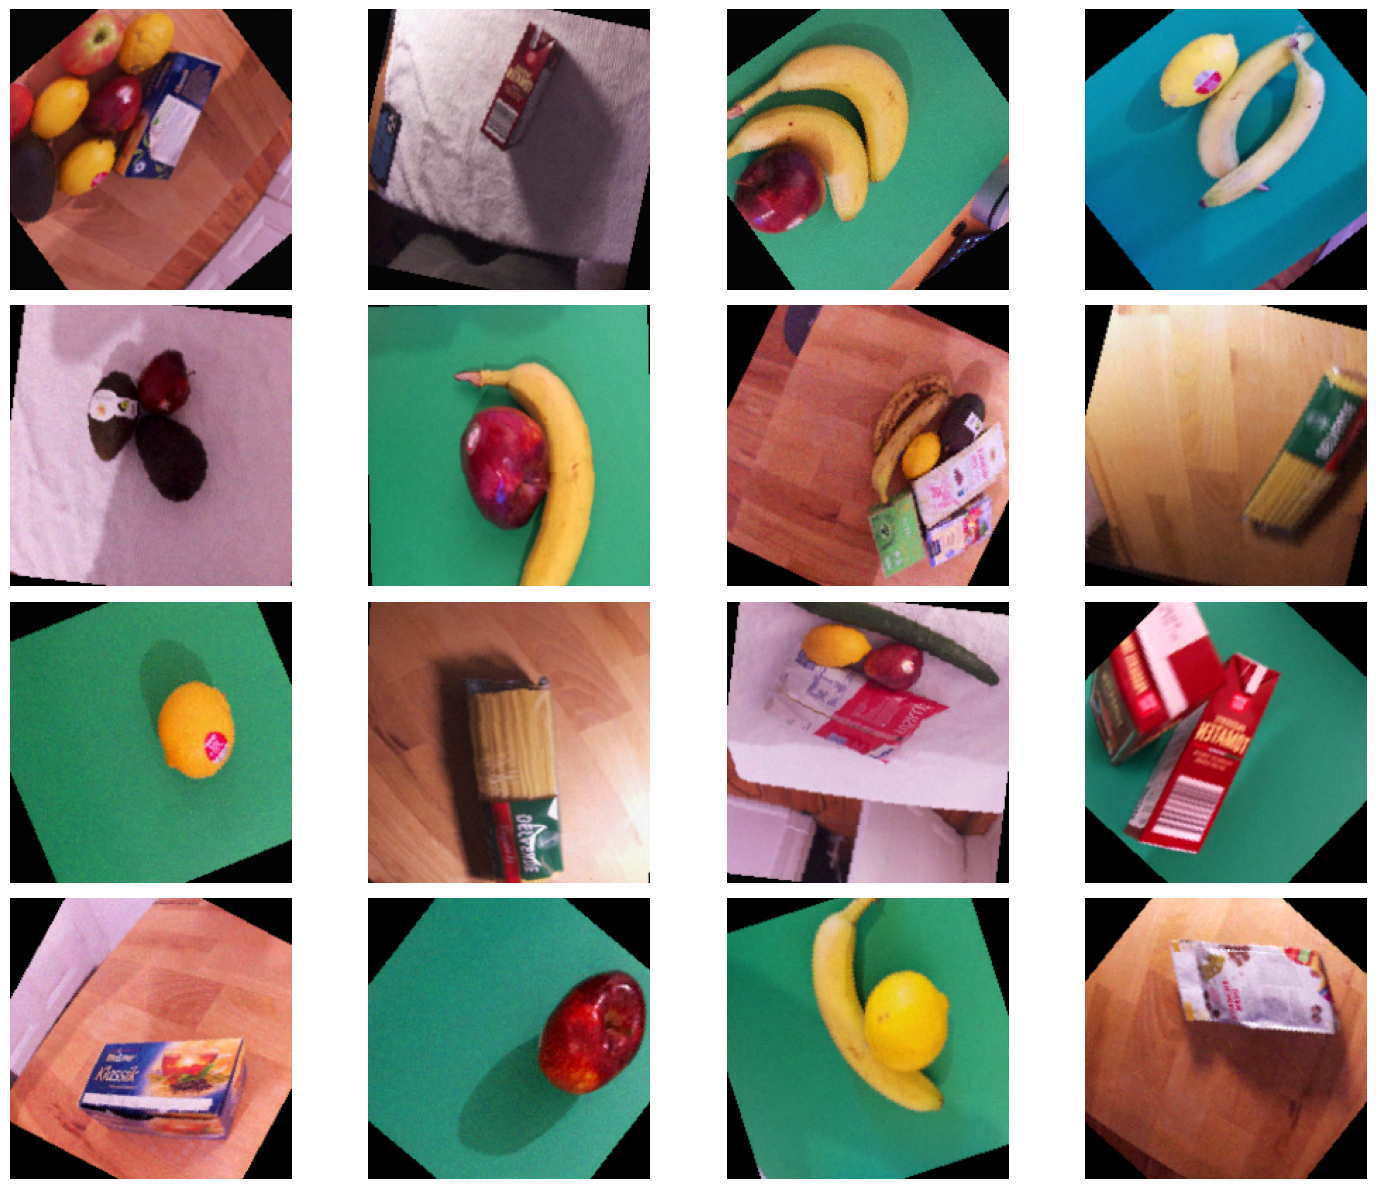

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Funktion zum Anzeigen von Bildern
def imshow(image, ax=None):
    # Wenn kein Ax angegeben wird, erstelle eine neue Achse
    if ax is None:
        fig, ax = plt.subplots()
        
    # Wandle den Tensor in ein NumPy-Array um und skaliere die Werte zurück auf [0, 1]
    image = image.permute(1, 2, 0).numpy()  # Von (C, H, W) nach (H, W, C)
    image = np.clip(image, 0, 1)  # Begrenze den Wertebereich auf [0, 1]
    
    ax.imshow(image)
    ax.axis('off')

# Hole ein Batch von Bildern aus dem DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Zeige die ersten 5 Bilder im Batch
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4 Zeilen, 5 Spalten
axes = axes.flatten()  # Flatten der 2D Achsenmatrix, um sie einfach zu durchlaufen

# Zeige die Bilder
for i in range(16):
    imshow(images[i], axes[i])  # Stelle jedes Bild in der jeweiligen Achse dar

# Zeige die Bilder
plt.tight_layout()  # Optimiert das Layout für bessere Übersicht
plt.show()


## classification Model

In [10]:
class RegressionModel(pl.LightningModule):
    def __init__(self, num_classes=num_clases, num_layers=6, num_filters=[32,32,32,32,32,32], pooling = [[1,2,3],[4]], kernel_size=3, learning_rate=1e-3):
        super().__init__()
        layers = []
        in_channels = 3  # Input-Kanäle, z. B. RGB-Bilder
        self.learning_rate = learning_rate
        self.optimizer = None
        
        # Convolutional Layers
        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, num_filters[i], kernel_size, padding="same", stride=1))
            layers.append(nn.ReLU())
            if i in pooling[0]: 
                layers.append(nn.MaxPool2d(kernel_size=2))
            elif i in pooling[1]:
                layers.append(nn.MaxPool2d(kernel_size=3))

            in_channels = num_filters[i]
        
        layers.append(nn.Flatten())
        # Die Ausgabe-Schicht nun für `num_classes` Klassen
        layers.append(nn.Linear(num_filters[len(num_filters)-1]*64, 512))  # Beispielhafte Größenanpassung
        layers.append(nn.ReLU())
        layers.append(nn.Linear(512, num_classes))  # Zahl der Klassen als Ausgangsgrößen
        
        self.model = nn.Sequential(*layers)
        
        self.criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss für Multi-Label-Klassifikation
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)  # Vorhersage für jede Klasse (Multilabel)
        
        # Verlustberechnung: Binary Cross-Entropy Loss
        loss = self.criterion(y_pred, y)  # y ist hier der Label-Vektor, der die Häufigkeit der Klassen darstellt
        
        # Logs
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        
        # Logs
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        
        self.log("test_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Erstelle einen Scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.965)
        # Alternativ: andere Scheduler wie CosineAnnealingLR, ReduceLROnPlateau, etc.
        
        return [self.optimizer], [scheduler]

In [12]:
import torch
import random
import matplotlib.pyplot as plt
import wandb

def show_predictions_with_prices_and_manual_metrics(model, test_dataset, prices, num_samples=20, threshold=0.5):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    samples = random.sample(range(len(test_dataset)), num_samples)  # Wähle zufällig Samples aus

    all_true_prices = []
    all_predicted_prices = []

    for idx in samples:
        image, labels = test_dataset[idx]  # Lade das Bild und die Multi-Label Labels
        image_tensor = image.unsqueeze(0).to(model.device)  # Füge Batch-Dimension hinzu und verschiebe auf GPU/CPU

        # Vorhersage erzeugen
        with torch.no_grad():
            prediction = model(image_tensor).cpu().squeeze()  # Entferne die Batch-Dimension und bringe auf CPU

        # Erstelle ein Dictionary für Vorhersagen über dem Schwellenwert
        predicted_labels = {i: pred.item() for i, pred in enumerate(prediction) if pred.item() > threshold}
        
        # Erstelle ein Dictionary für die tatsächlichen Labels (hier annehmen, dass 1 für das Vorhandensein einer Klasse steht)
        true_labels = {i: label.item() for i, label in enumerate(labels) if label.item() > 0.5}

        # Berechne die Gesamtpreise basierend auf den Labels
        true_price = sum(prices[label][1] for label in true_labels.keys() if label in prices)
        predicted_price = sum(prices[label][1] for label in predicted_labels.keys() if label in prices)

        # Speichere die Preise für die Metrikberechnung
        all_true_prices.append(true_price)
        all_predicted_prices.append(predicted_price)

        # Formatierte Strings für die Anzeige
        predicted_labels_str = "\n".join([f"{prices[key][0]}: {value:.2f} €" for key, value in predicted_labels.items() if key in prices])
        true_labels_str = "\n".join([f"{prices[key][0]}: {value:.2f} €" for key, value in true_labels.items() if key in prices])

        # Bild anzeigen
        plt.figure(figsize=(6, 6))
        plt.imshow(image.permute(1, 2, 0))  # Konvertiere das Tensor-Bild in HWC-Format
        plt.title(f"True Labels:\n{true_labels_str}\nTrue Price: {true_price:.2f} €\n\n"
                  f"Predictions:\n{predicted_labels_str}\nPredicted Price: {predicted_price:.2f} €")
        plt.axis("off")
        plt.show()

        try:
            wandb.log({"predictions": wandb.Image(plt)})
        except Exception as e:
            print(f"Couldn't log predictions to wandb: {e}")

    # Manuelle Berechnung von MSE und MAE
    mse = sum((true - pred) ** 2 for true, pred in zip(all_true_prices, all_predicted_prices)) / len(all_true_prices)
    mae = sum(abs(true - pred) for true, pred in zip(all_true_prices, all_predicted_prices)) / len(all_true_prices)

    # MSE und MAE ausgeben
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    return mse, mae




def configure_wandb(additional_name="", tags=[]):
    # Sort the dataset names aplhabetically
    dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))
    group = "Regression-"+dataset_names
    name = dataset_names+additional_name+"_"+datetime.now().strftime("%d%b-%H:%M:%S")

    wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name, tags=tags)   
    wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED}) # Log additional hyperparameters

    return wandb_logger

In [13]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Track validation loss
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Checkpoint file name
    save_top_k=1,  # Save only the best model (lowest val_loss)
    mode='min',  # We are minimizing validation loss
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    mode="min",      
    min_delta=0.1,
    patience=5,          
    verbose=True       
)

In [ ]:
model = RegressionModel(num_filters= [32, 32, 32, 32, 32, 32], num_layers=6, kernel_size=3, learning_rate= 0.002).to("cpu")
model.to(device)
summary(model, input_size=(3, 200, 200))


try:
    trainer = pl.Trainer(max_epochs=15, logger=configure_wandb(), callbacks=[checkpoint_callback], fast_dev_run=False, accelerator=str(device), devices=1)

    trainer.fit(model, train_loader, val_loader) 

    # Load the best checkpoint (lowest validation loss)
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model saved at: {best_model_path}")

    # Load the best model for testing
    model = RegressionModel.load_from_checkpoint(best_model_path)
    # Model Testing
    trainer.test(model, test_loader)

    # Metrics and predictions
    #metrics = trainer.callback_metrics
    print("hier bin ich")
    show_predictions_with_prices_and_manual_metrics(model, test_dataset)
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    wandb.finish()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
            Conv2d-3         [-1, 32, 200, 200]           9,248
              ReLU-4         [-1, 32, 200, 200]               0
         MaxPool2d-5         [-1, 32, 100, 100]               0
            Conv2d-6         [-1, 32, 100, 100]           9,248
              ReLU-7         [-1, 32, 100, 100]               0
         MaxPool2d-8           [-1, 32, 50, 50]               0
            Conv2d-9           [-1, 32, 50, 50]           9,248
             ReLU-10           [-1, 32, 50, 50]               0
        MaxPool2d-11           [-1, 32, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]           9,248
             ReLU-13           [-1, 32, 25, 25]               0
        MaxPool2d-14             [-1, 3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/torgeschwark/miniconda3/envs/MLubu/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/torgeschwark/TinyML-MT/training-code/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 1.1 M  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.510     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 8:  53%|█████▎    | 42/79 [00:11<00:10,  3.69it/s, v_num=digf, train_loss_step=0.0883, val_loss=0.0853, train_loss_epoch=0.0848] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


An error occurred: name 'exit' is not defined


## Efficient NET

In [14]:
prices = hp.get_combined_dict(PRICES_FILE_PATH)
print(prices)

{1: ['apple', 0.6], 2: ['lemon', 0.49], 3: ['avocado', 1.29], 4: ['banana', 0.46], 5: ['tomato sauce', 1.19], 6: ['schweppes', 2.19], 7: ['vitamine water', 1.19], 8: ['salt', 1.29], 9: ['pasta', 2.69], 10: ['brush', 0.79], 11: ['red fruit jelly', 2.29], 12: ['cup noodles ', 2.19], 13: ['coffee', 7.99], 14: ['lemon cake baking mix ', 3.49], 15: ['lettuce', 1.11], 16: ['bread', 1.89], 17: ['curry sauce', 2.29], 18: ['tomato ketchup', 2.29], 19: ['lemon juice', 1.59], 20: ['spaghetti', 1.29], 21: ['kinder riegel', 2.99], 22: ['beetroot', 1.79], 23: ['pickles', 3.49], 24: ['detergent', 3.79], 25: ['maggi wok', 1.05], 26: ['tea', 2.35], 27: ['nic nacs', 1.99], 28: ['pedigree dog food', 2.29], 29: ['pringles', 2.49], 30: ['balsamico', 2.69], 31: ['cat food bowl', 0.65], 32: ['potatoes', 1.99], 33: ['red tea', 2.49], 34: ['hella water', 0.79], 35: ['gouda', 2.19], 36: ['oat milk', 0.99], 37: ['salami', 1.79], 38: ['chickpeas', 0.59], 39: ['cereals', 2.49], 40: ['packaged cereal bars', 1.99], 

In [27]:
class TrainModel(pl.LightningModule):
    def __init__(self, model, prices, learning_rate=1e-3, optimizer=None):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.model = model
        self.prices = prices
        self.criterion = nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        self.optimizer = optimizer
        self.threshold = 0.5
        self.save_hyperparameters() #ignore=['model']

    def forward(self, x):
        return self.model(x)

    def calculate_total_price(self, predictions, labels):
        """
        Berechnet den Gesamtpreis basierend auf den Vorhersagen und tatsächlichen Labels
        """
        # Vorhersagen und tatsächliche Labels basierend auf Threshold filtern
        predicted_labels = [i for i, pred in enumerate(predictions) if pred > self.threshold]
        true_labels = [i for i, label in enumerate(labels) if label > 0.5]

        # Berechnung der Gesamtpreise
        predicted_price = sum(self.prices[label][1] for label in predicted_labels if label in self.prices)
        true_price = sum(self.prices[label][1] for label in true_labels if label in self.prices)

        return predicted_price, true_price

    def step(self, batch, stage):
        x, y = batch
        y_pred = self(x)  # Vorhersagen

        # Hauptverlust berechnen (MSE auf allen Labels)
        loss = self.criterion(y_pred, y)

        # MAE und MSE der Hauptlabels
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Berechnung der Gesamtpreise
        batch_predicted_prices = []
        batch_true_prices = []
        for i in range(len(y)):
            predicted_price, true_price = self.calculate_total_price(y_pred[i], y[i])
            batch_predicted_prices.append(predicted_price)
            batch_true_prices.append(true_price)

        # Manuelle Berechnung von MAE und MSE für Gesamtpreise
        total_mae = sum(abs(tp - pp) for tp, pp in zip(batch_true_prices, batch_predicted_prices)) / len(batch_true_prices)
        total_mse = sum((tp - pp) ** 2 for tp, pp in zip(batch_true_prices, batch_predicted_prices)) / len(batch_true_prices)

        # Logs für Progress-Bar und Training/Validierung/Test
        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_mae", mae, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_mse", mse, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_total_mae", total_mae, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_total_mse", total_mse, prog_bar=True, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, stage="val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, stage="test")

    def configure_optimizers(self):
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Scheduler erstellen
        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.965)
        return [self.optimizer], [scheduler]


In [24]:
from torchvision.models import efficientnet_b0

def getEfficientnetRegression():
    # Load EfficientNet-B0 with pretrained weights
    model = efficientnet_b0(weights="IMAGENET1K_V1")
    print(model)

    # Replace head
    output = model.features[-1][0].out_channels  # Output channels of the last block

    # Define custom regression head
    regression_head = nn.Sequential(
        nn.Linear(output, 200),  # Adjust input size as needed
        nn.ReLU(),
        nn.Linear(200, 200),
        nn.ReLU(),
        nn.Linear(200, 100),
        nn.ReLU(),
        nn.Linear(100, num_clases)
    )

    # Replace the classifier with your regression head
    model.classifier = regression_head
    return model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/home/torgeschwark/miniconda3/envs/MLubu/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/torgeschwark/miniconda3/envs/MLubu/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/torgeschwark/TinyML-MT/training-code/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | EfficientNet      | 4.3 M  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
--------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.321    Total estimated model params size (MB)
345       Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 79/79 [01:24<00:00,  0.94it/s, v_num=0b9l, train_loss_step=0.000387, train_mae_step=0.00928, train_mse_step=0.000387, train_total_mae_step=0.000, train_total_mse_step=0.000, val_loss=0.000349, val_mae=0.00874, val_mse=0.000349, val_total_mae=0.000475, val_total_mse=0.000285, train_loss_epoch=0.00051, train_mae_epoch=0.0103, train_mse_epoch=0.00051, train_total_mae_epoch=0.000119, train_total_mse_epoch=7.12e-5]    


Restoring states from the checkpoint path at /home/torgeschwark/TinyML-MT/training-code/checkpoints/custom_local_data_Efficientnet-classifier_18Jan-18:04:05.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/torgeschwark/TinyML-MT/training-code/checkpoints/custom_local_data_Efficientnet-classifier_18Jan-18:04:05.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:11<00:00,  0.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.007594936527311802
        test_mae           0.024624880403280258
        test_mse           0.007594936527311802
     test_total_mae         0.3646176755428314
     test_total_mse          0.97337806224823
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


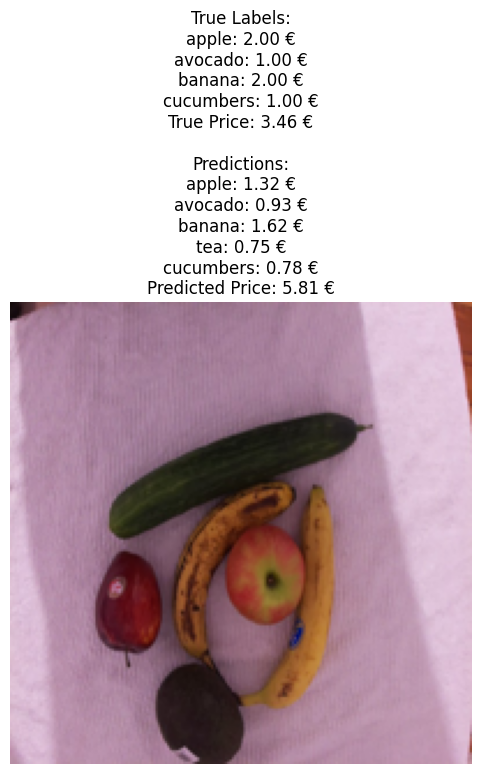

<Figure size 640x480 with 0 Axes>

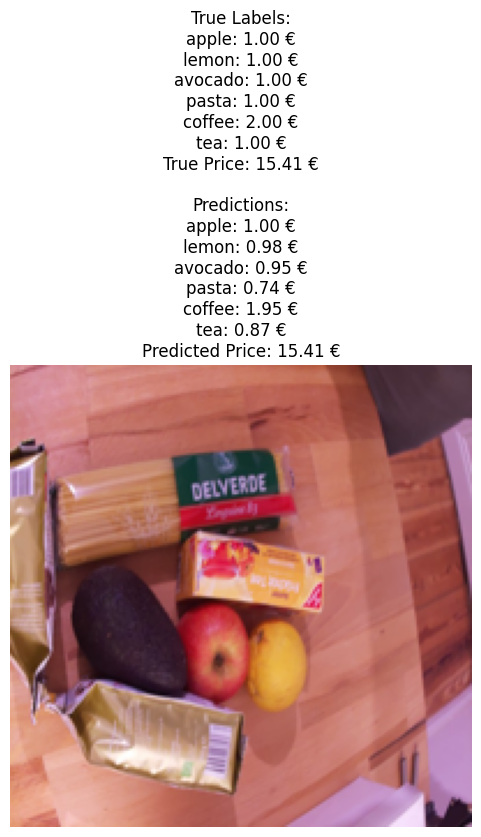

<Figure size 640x480 with 0 Axes>

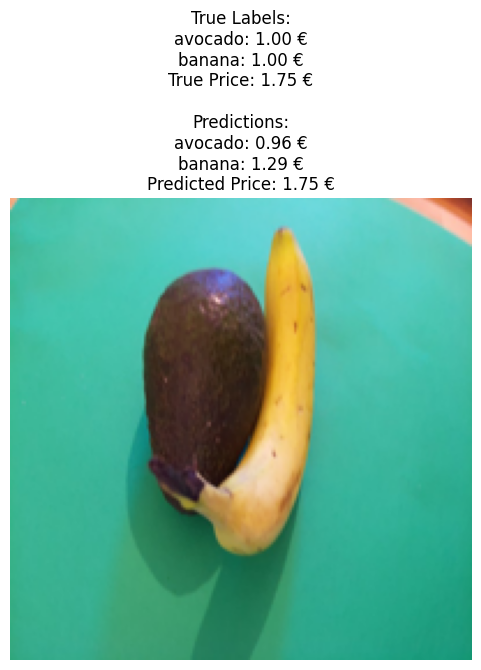

<Figure size 640x480 with 0 Axes>

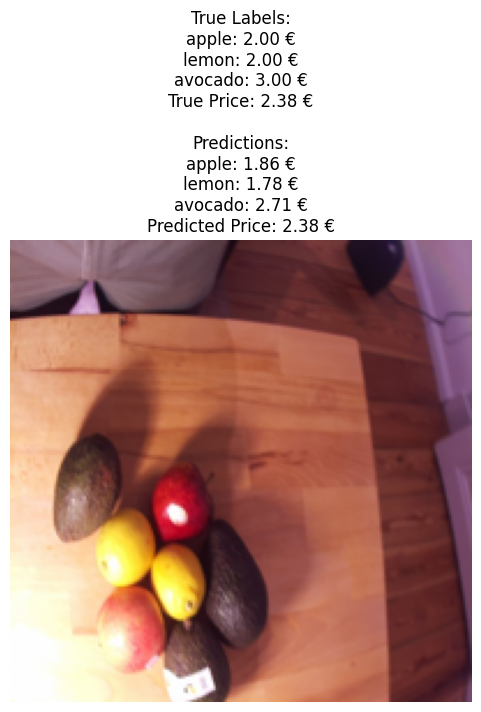

<Figure size 640x480 with 0 Axes>

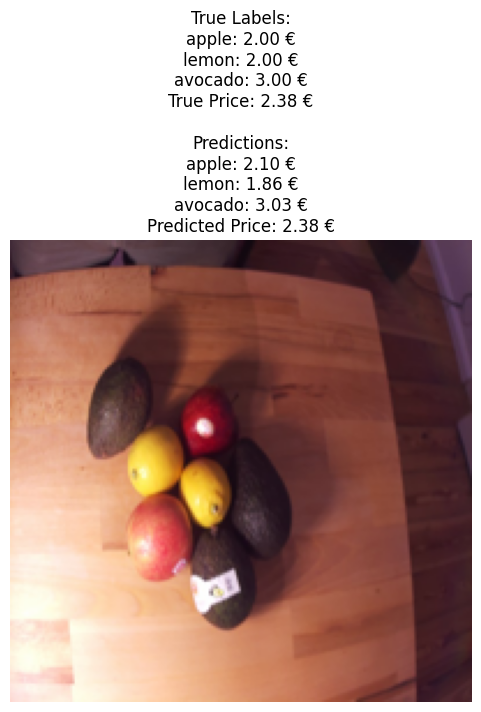

<Figure size 640x480 with 0 Axes>

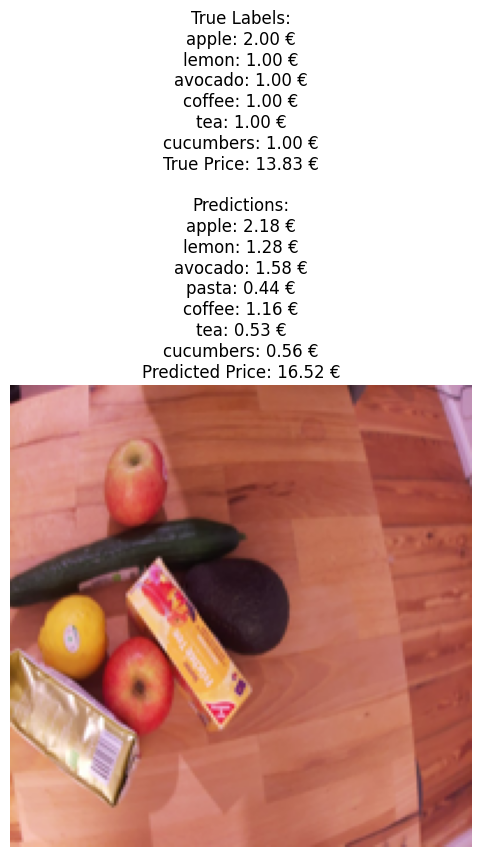

<Figure size 640x480 with 0 Axes>

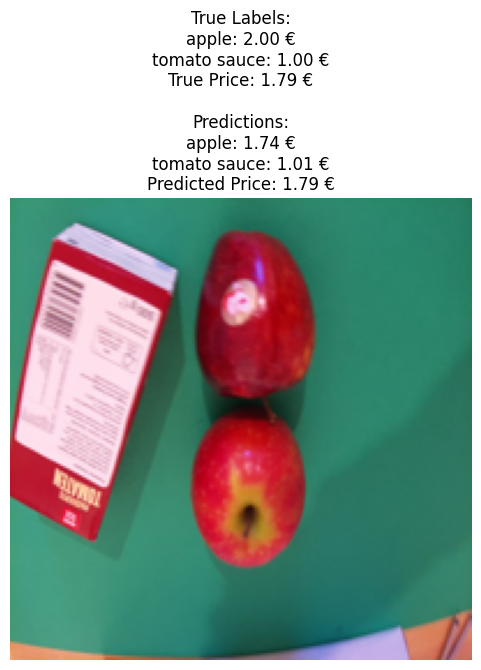

<Figure size 640x480 with 0 Axes>

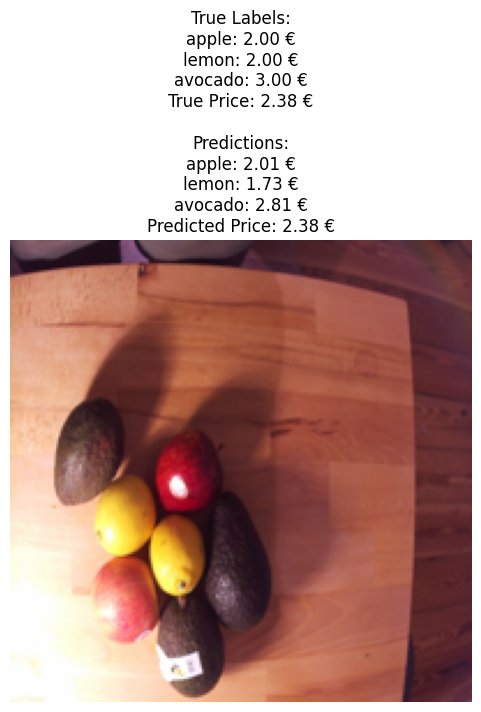

<Figure size 640x480 with 0 Axes>

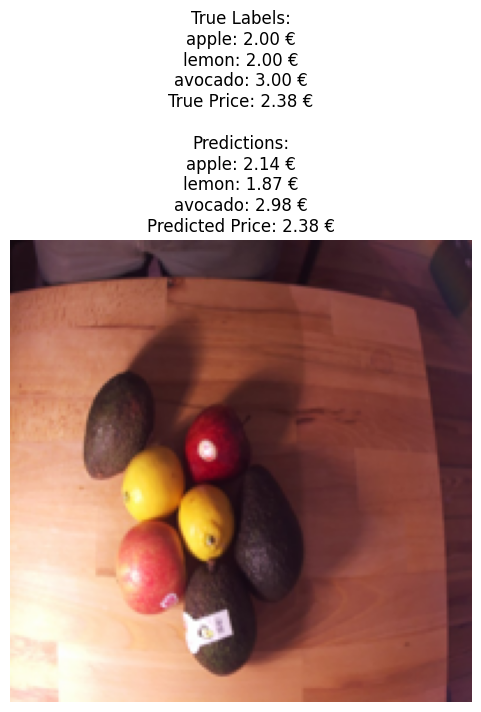

<Figure size 640x480 with 0 Axes>

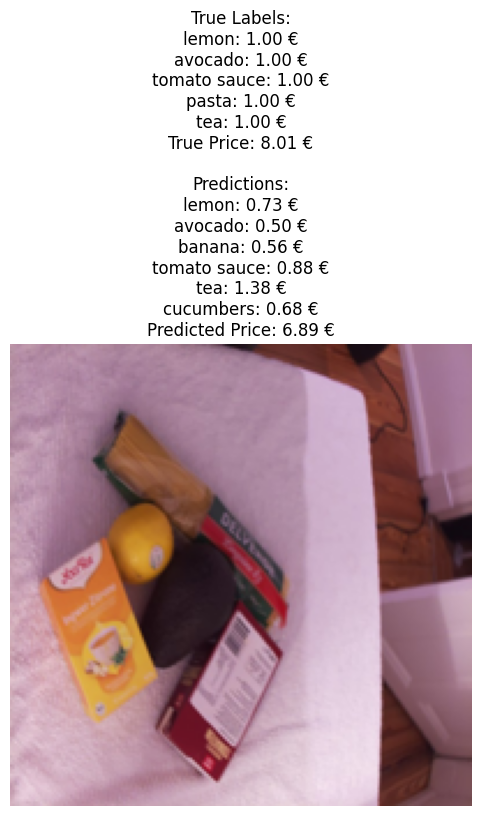

<Figure size 640x480 with 0 Axes>

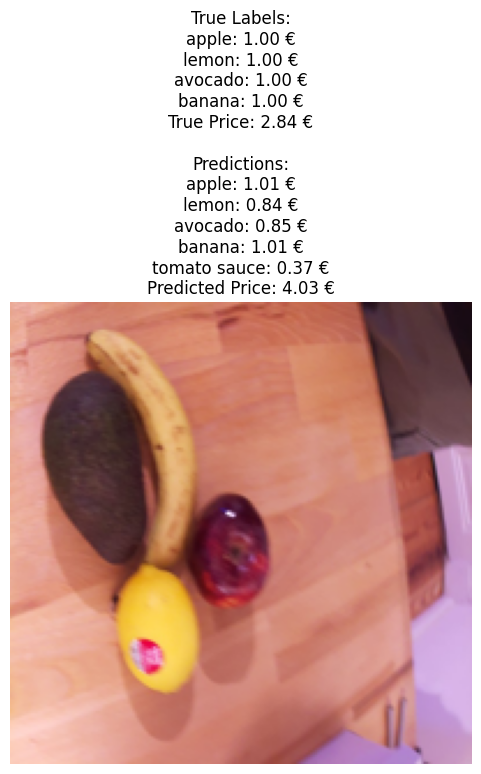

<Figure size 640x480 with 0 Axes>

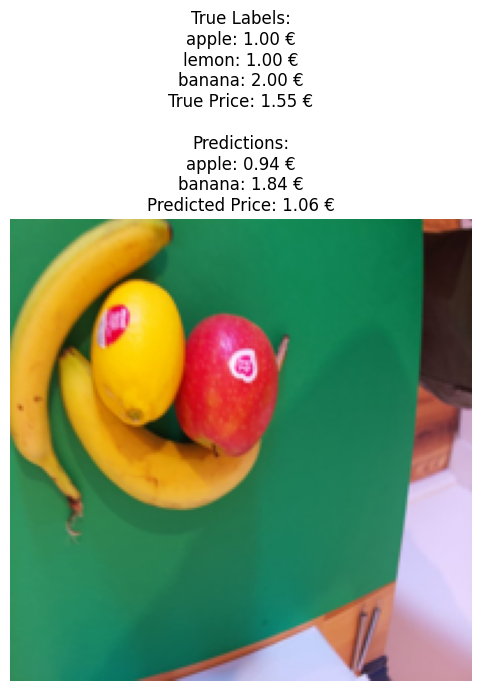

<Figure size 640x480 with 0 Axes>

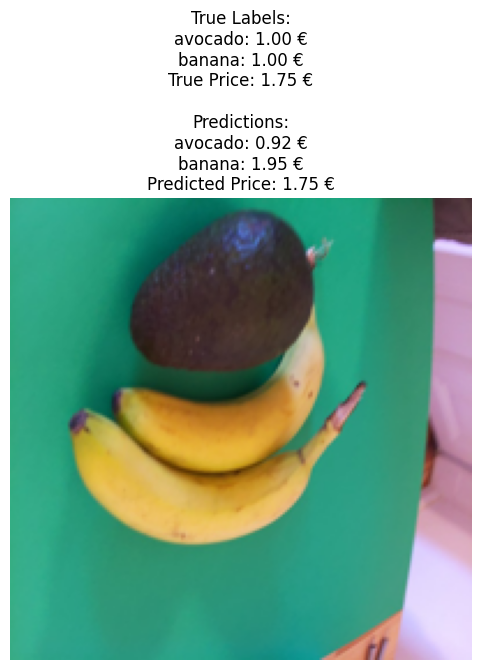

<Figure size 640x480 with 0 Axes>

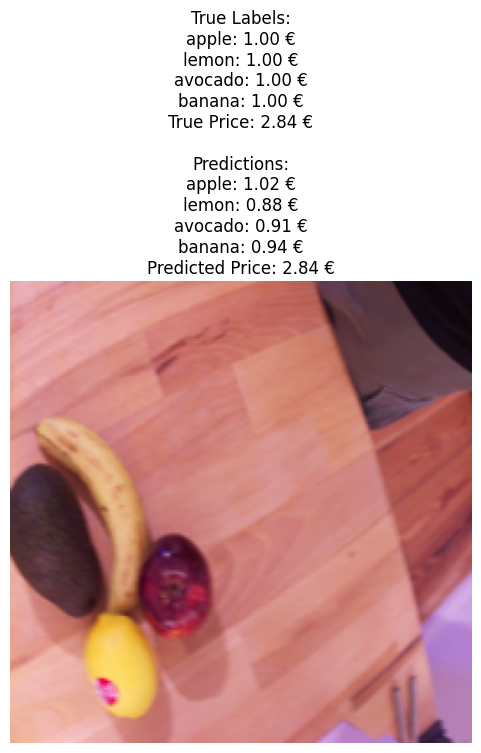

<Figure size 640x480 with 0 Axes>

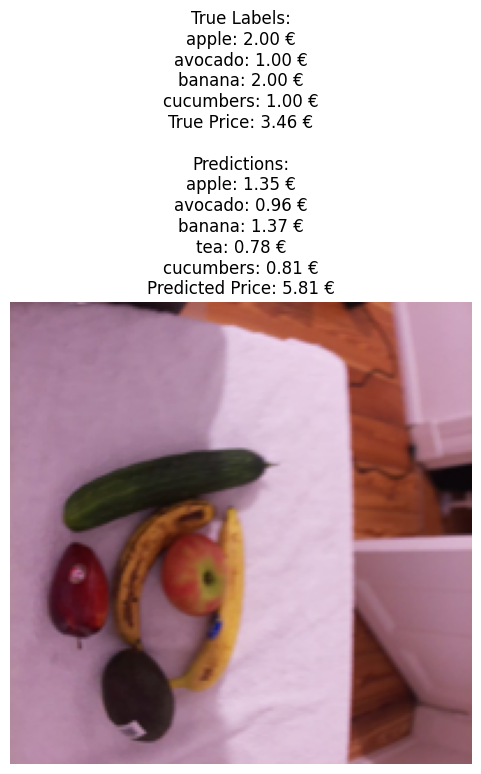

<Figure size 640x480 with 0 Axes>

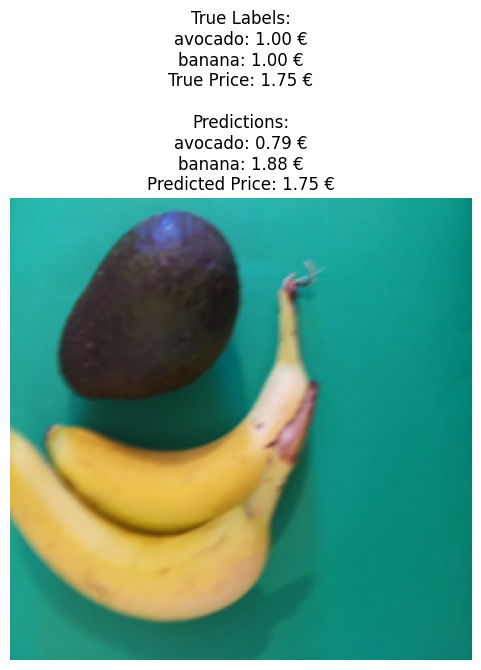

<Figure size 640x480 with 0 Axes>

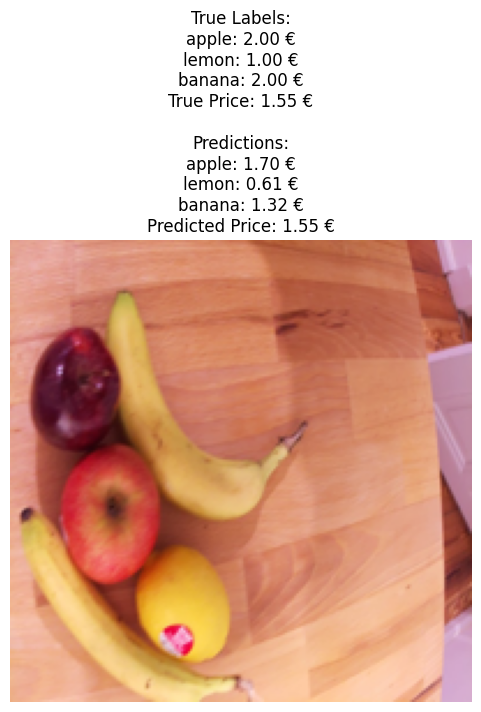

<Figure size 640x480 with 0 Axes>

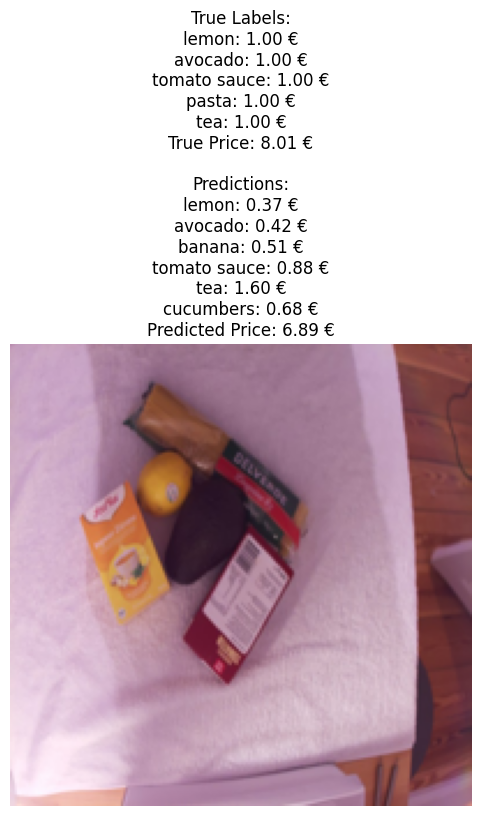

<Figure size 640x480 with 0 Axes>

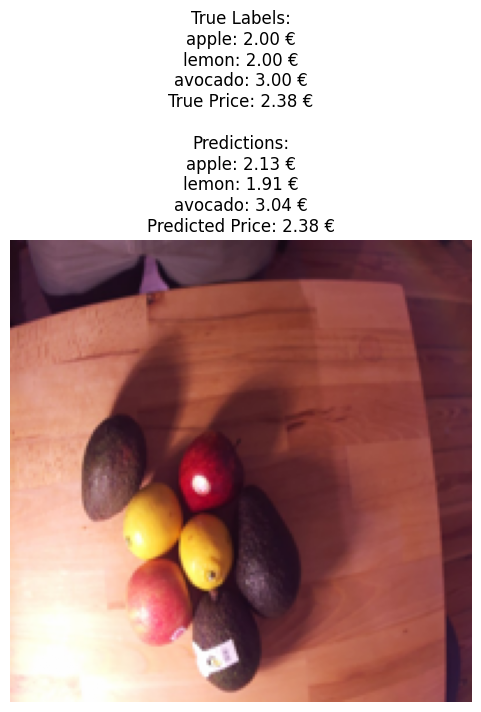

<Figure size 640x480 with 0 Axes>

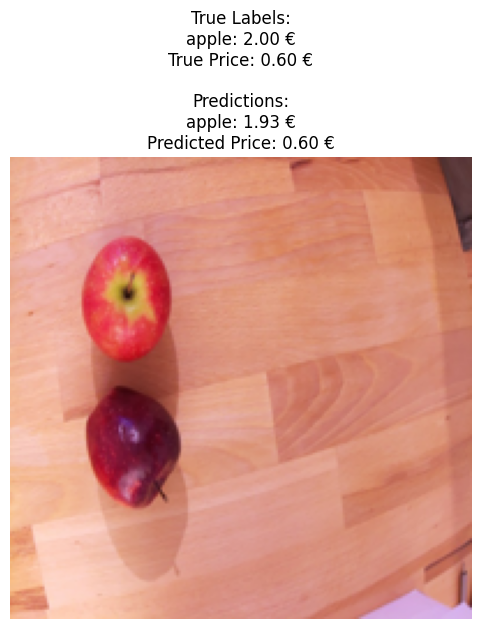

Mean Squared Error (MSE): 1.12
Mean Absolute Error (MAE): 0.57


<Figure size 640x480 with 0 Axes>

In [28]:
model = TrainModel(getEfficientnetRegression(), prices)
model.to(device)
summary(model, input_size=(3, 200, 200))

wandb_logger = configure_wandb(additional_name="_Efficientnet-classifier", tags=["Efficientnet"])


checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Track validation loss
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename=wandb_logger.experiment.name,  # Checkpoint file name
    save_top_k=1,  # Save only the best model (lowest val_loss)
    mode='min',  # We are minimizing validation loss
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    mode="min",      
    min_delta=0.03,
    patience=8,          
)


try:
    trainer = pl.Trainer(max_epochs=15, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping], fast_dev_run=False, accelerator=str(device), devices=1)

    trainer.fit(model, train_loader, val_loader) 

    # Load the best model for testing
    trainer.test(model, test_loader, ckpt_path=checkpoint_callback.best_model_path)

    show_predictions_with_prices_and_manual_metrics(model, test_dataset, prices)
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    wandb.finish()
